<a href="https://colab.research.google.com/github/PandukaBandara99/ML-Books/blob/main/MLOPS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mahela Panduka Bandara ; <br>
UG @ Dpt. of Electronic & Electrical Engineering ;<br>
University of Peradeniya ;<br>
2024/3<br>

Email : e19039@end.pdn.ac.lk<br>
LinkedIN : https://www.linkedin.com/in/pandukabandara/<br>

References :https://www.coursera.org/specializations/machine-learning-engineering-for-production-mlops

# 1.0 Neural Architecture Search


## 1.1 Hyperparameter tuning

### 1.1.1 Neural Architecture Search


> Neural architecture search (NAS) is is a technique for automating the
design of artificial neural networks.It helps finding the optimal architecture.AutoML is an algorithm to automate this search

Two types of parameters in an ML model.

1. Trainable parameters:Learned by the algorithm during training
    - e.g. weights of a neural network
2.  Hyperparameters: set before launching the learning process
    - e.g: learning rate or the number of units in a dense layer

Manual hyperparameter tuning is not scalable.Tuning them manually can be a real brain teaser.

> Automating hyperparameter tuning can be done with with **Keras Tuner**




### 1.1.2 Intro to Keras Tuner

#### Download and prepare the dataset

Let us first load the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) into your workspace.

In [1]:
# Import keras
from tensorflow import keras

In [2]:
# Download the dataset and split into train and test sets
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


For preprocessing, normalize the pixel values to make the training converge faster.

In [3]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

#### Baseline Performance

First have a baseline performance using arbitrarily handpicked parameters so the developer can compare the results later.

In [4]:
# Build the baseline model using the Sequential API
b_model = keras.Sequential()
b_model.add(keras.layers.Flatten(input_shape=(28, 28)))
b_model.add(keras.layers.Dense(units=512, activation='relu', name='dense_1')) # You will tune this layer later
b_model.add(keras.layers.Dropout(0.2))
b_model.add(keras.layers.Dense(10, activation='softmax'))

# Print model summary
b_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Then setup the loss, metrics, and the optimizer. The learning rate is also a hyperparameter that can tune automatically but for now,set it at `0.001`.

In [5]:
# Setup the training parameters
b_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

With all settings set,start training the model.

In [6]:
# Number of training epochs.
NUM_EPOCHS = 10

# Train the model
b_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 19s 12ms/step - loss: 0.5160 - accuracy: 0.8154 - val_loss: 0.3935 - val_accuracy: 0.8593
Epoch 2/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3905 - accuracy: 0.8570 - val_loss: 0.3590 - val_accuracy: 0.8737
Epoch 3/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3553 - accuracy: 0.8692 - val_loss: 0.3711 - val_accuracy: 0.8673
Epoch 4/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3346 - accuracy: 0.8758 - val_loss: 0.3454 - val_accuracy: 0.8727
Epoch 5/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.3160 - accuracy: 0.8834 - val_loss: 0.3317 - val_accuracy: 0.8812
Epoch 6/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3000 - accuracy: 0.8888 - val_loss: 0.3328 - val_accuracy: 0.8783
Epoch 7/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2901 - accuracy: 0.8920 - val_loss: 0.3067 -

Finally, performs against the test set.

In [7]:
# Evaluate model on the test set
b_eval_dict = b_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.8842


Define a helper function for displaying the results so it's easier to compare later.

In [9]:
# Define helper function
def print_results(model, model_name, layer_name, eval_dict):
  '''
  Prints the values of the hyparameters to tune, and the results of model evaluation

  Args:
    model (Model) - Keras model to evaluate
    model_name (string) - arbitrary string to be used in identifying the model
    layer_name (string) - name of the layer to tune
    eval_dict (dict) -  results of model.evaluate
  '''
  print(f'\n{model_name}:')

  print(f'number of units in 1st Dense layer: {model.get_layer(layer_name).units}')
  print(f'learning rate for the optimizer: {model.optimizer.lr.numpy()}')

  for key,value in eval_dict.items():
    print(f'{key}: {value}')

# Print results for baseline model
print_results(b_model, 'BASELINE MODEL', 'dense_1', b_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3342683017253876
accuracy: 0.8841999769210815


#### Keras Tuner

To perform hypertuning with Keras Tuner, need to:

* Define the model
* Select which hyperparameters to tune
* Define its search space
* Define the search strategy

##### Install and import packages



In [10]:
# Install Keras Tuner
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [11]:
# Import required packages
import tensorflow as tf
import keras_tuner as kt

##### Define the model

The model set up for hypertuning is called a *hypermodel*. When build this model, need to define the hyperparameter search space in addition to the model architecture.

Candefine a hypermodel through two approaches:

* By using a model builder function
* By [subclassing the `HyperModel` class](https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function) of the Keras Tuner API

The function below basically builds the same model used earlier. The difference is there are two hyperparameters that are setup for tuning:

* the number of hidden units of the first Dense layer
* the learning rate of the Adam optimizer

* use its `Int()` method to define the search space for the Dense units. This allows to set a minimum and maximum value, as well as the step size when incrementing between these values.

* use its `Choice()` method for the learning rate. This allows to define discrete values to include in the search space when hypertuning.



In [12]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''

  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='tuned_dense_1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

##### Instantiate the Tuner and perform hypertuning



Now that you have the model builder, you can then define how the tuner can find the optimal set of hyperparameters, also called the search strategy. Keras Tuner has [four tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) available with built-in strategies - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.

Strategies for Karas Auto Tuner:

| Strategy              | Description                                                                                                                                                                                                                                                                                           | Pros                                                                                                            | Cons                                                                                                                   |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| RandomSearch          | Randomly selects hyperparameter combinations from a predefined search space.                                                                                                                                                                                                                         | - Simple to implement - Good for initial exploration of hyperparameter space - May find good solutions with fewer evaluations                                               | - Can be inefficient for large search spaces - Doesn't adapt based on previous evaluations                                 |
| Hyperband             | Implements the Hyperband algorithm, which performs successive halving of configurations with different resource allocations (epochs). Prunes poorly performing configurations early on.                                                                                                          | - Efficiently allocates resources to promising configurations - Good for large search spaces - Provides trade-off between exploration and exploitation                                                                       | - Requires specifying a maximum resource budget - May not perform optimally with very small budgets                           |
| Bayesian Optimization| Utilizes Bayesian optimization techniques to model the objective function and decide which hyperparameter configurations to explore next based on previous evaluations.                                                                                                                               | - Efficiently explores the hyperparameter space, focusing on promising regions - Adapts to previous evaluations, leading to faster convergence                                            | - Requires careful specification of prior beliefs and parameterization - Computationally more expensive than random search       |
| Sklearn               | Integrates with scikit-learn's GridSearchCV or RandomizedSearchCV, which perform exhaustive or random search over a specified hyperparameter grid.                                                                                                                                                 | - Well-documented and widely-used - Works seamlessly with scikit-learn models - Easy to parallelize for faster search                                                               | - Can be computationally expensive, especially with large search spaces - May not efficiently explore continuous hyperparameter spaces |
| Genetic Algorithms   | Evolves a population of hyperparameter configurations over multiple generations using principles inspired by biological evolution, such as selection, crossover, and mutation.                                                                                                                    | - Can handle non-linear and non-convex search spaces - Well-suited for discrete and combinatorial hyperparameters - May find novel solutions not explored by other methods                      | - Computationally expensive, especially with large populations and generations - Requires careful tuning of genetic operators |
| Tree-structured Parzen Estimator (TPE) | Utilizes a tree-structured Parzen estimator to model the objective function and select promising hyperparameter configurations to explore next, focusing on regions likely to improve performance.                                                                                                   | - Efficiently explores the hyperparameter space, focusing on promising regions - Adapts to previous evaluations, leading to faster convergence                                            | - May require tuning of TPE-specific parameters - Less intuitive than other methods                                          |
| Simulated Annealing   | Inspired by the physical annealing process, Simulated Annealing probabilistically accepts worse hyperparameter configurations with decreasing probability over time, allowing exploration of the search space while gradually focusing on promising regions.                                           | - Can escape local optima by accepting worse solutions with a certain probability - Can explore large search spaces efficiently - Well-suited for noisy or stochastic objective functions       | - Requires careful tuning of annealing schedule and acceptance criteria - May be slow to converge compared to other methods       |



Hyperband is an algorithm specifically developed for hyperparameter optimization. It uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket wherein the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. You can read about the intuition behind the algorithm in section 3 of [this paper](https://arxiv.org/pdf/1603.06560.pdf).

Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer. You will see these parameters (i.e. `factor` and `max_epochs` passed into the initializer below). In addition, you will also need to define the following to instantiate the Hyperband tuner:

* the hypermodel (built by your model builder function)
* the `objective` to optimize (e.g. validation accuracy)
* a `directory` to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
* the `project_name` to differentiate with other runs. This will be used as a subdirectory name under the `directory`.



In [13]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_dir',
                     project_name='kt_hyperband')

Let's see a summary of the hyperparameters that you will tune:

In [14]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Pass in a callback to stop training early when a metric is not improving. Below, we define an [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to monitor the validation loss and stop training if it's not improving after 5 epochs.

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above.

In [16]:
# Perform hypertuning
tuner.search(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.84375

Best val_accuracy So Far: 0.890500009059906
Total elapsed time: 00h 31m 02s


Now ,can get the top performing model with the [get_best_hyperparameters()](https://keras-team.github.io/keras-tuner/documentation/tuners/#get_best_hyperparameters-method)  method.

In [17]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



#### Build and train the model



Now with the best set of hyperparameters, rebuild the hypermodel with these values and retrain it.

In [18]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 tuned_dense_1 (Dense)       (None, 288)               226080    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2890      
                                                                 
Total params: 228970 (894.41 KB)
Trainable params: 228970 (894.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Train the hypertuned model
h_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.5205 - accuracy: 0.8135 - val_loss: 0.4036 - val_accuracy: 0.8545
Epoch 2/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3974 - accuracy: 0.8555 - val_loss: 0.3768 - val_accuracy: 0.8564
Epoch 3/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3619 - accuracy: 0.8677 - val_loss: 0.3442 - val_accuracy: 0.8758
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3394 - accuracy: 0.8736 - val_loss: 0.3677 - val_accuracy: 0.8585
Epoch 5/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3233 - accuracy: 0.8793 - val_loss: 0.3201 - val_accuracy: 0.8854
Epoch 6/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3057 - accuracy: 0.8844 - val_loss: 0.3255 - val_accuracy: 0.8852
Epoch 7/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2978 - accuracy: 0.8895 - val_loss: 0.3231 - val_ac

Get its performance against the test set.

In [20]:
# Evaluate the hypertuned model against the test set
h_eval_dict = h_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 3ms/step - loss: 0.3545 - accuracy: 0.8754


Compare the results we got with the baseline model we used at the start of the notebook. Results may vary but will usually get a model that has less units in the dense layer, while having comparable loss and accuracy. This indicates that reduced the model size and saved compute resources while still having more or less the same accuracy.

In [21]:
# Print results of the baseline and hypertuned model
print_results(b_model, 'BASELINE MODEL', 'dense_1', b_eval_dict)
print_results(h_model, 'HYPERTUNED MODEL', 'tuned_dense_1', h_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3342683017253876
accuracy: 0.8841999769210815

HYPERTUNED MODEL:
number of units in 1st Dense layer: 288
learning rate for the optimizer: 0.0010000000474974513
loss: 0.3545226752758026
accuracy: 0.8754000067710876


## 1.2 Intro to Automated Machine Learning(AutoML)

### 1.2.1 Neural Architecture Search


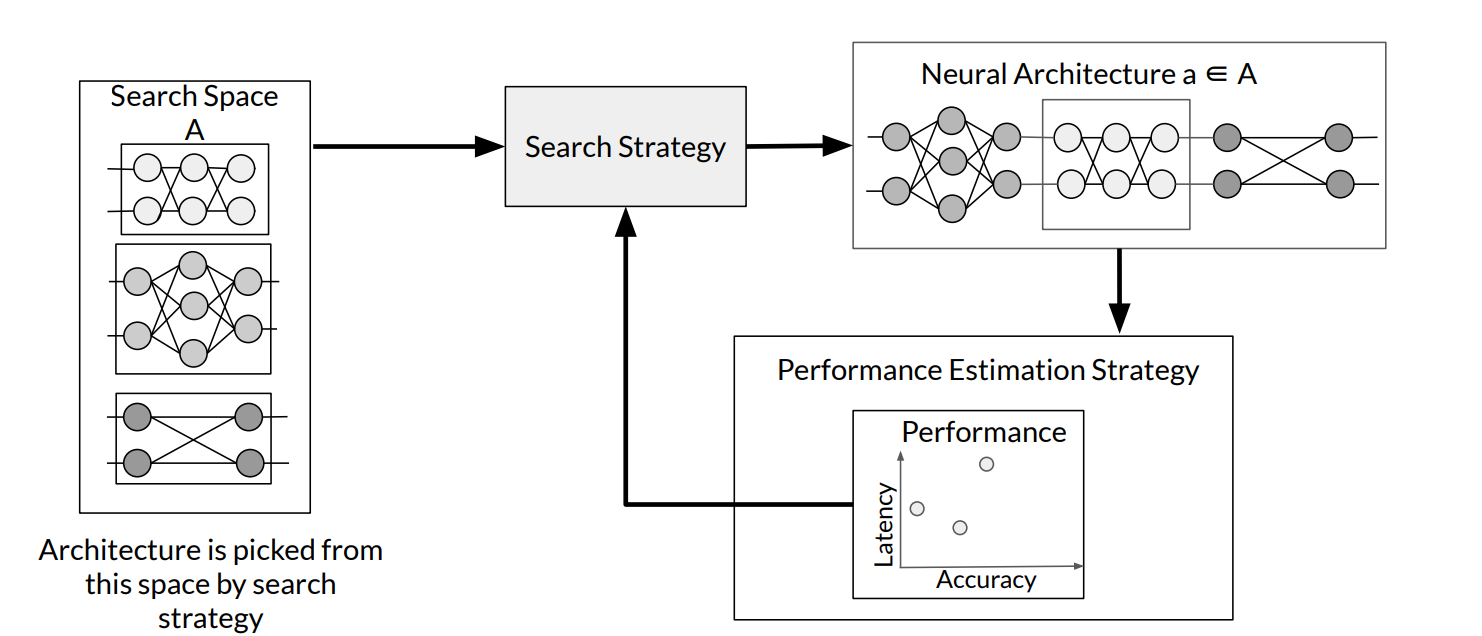

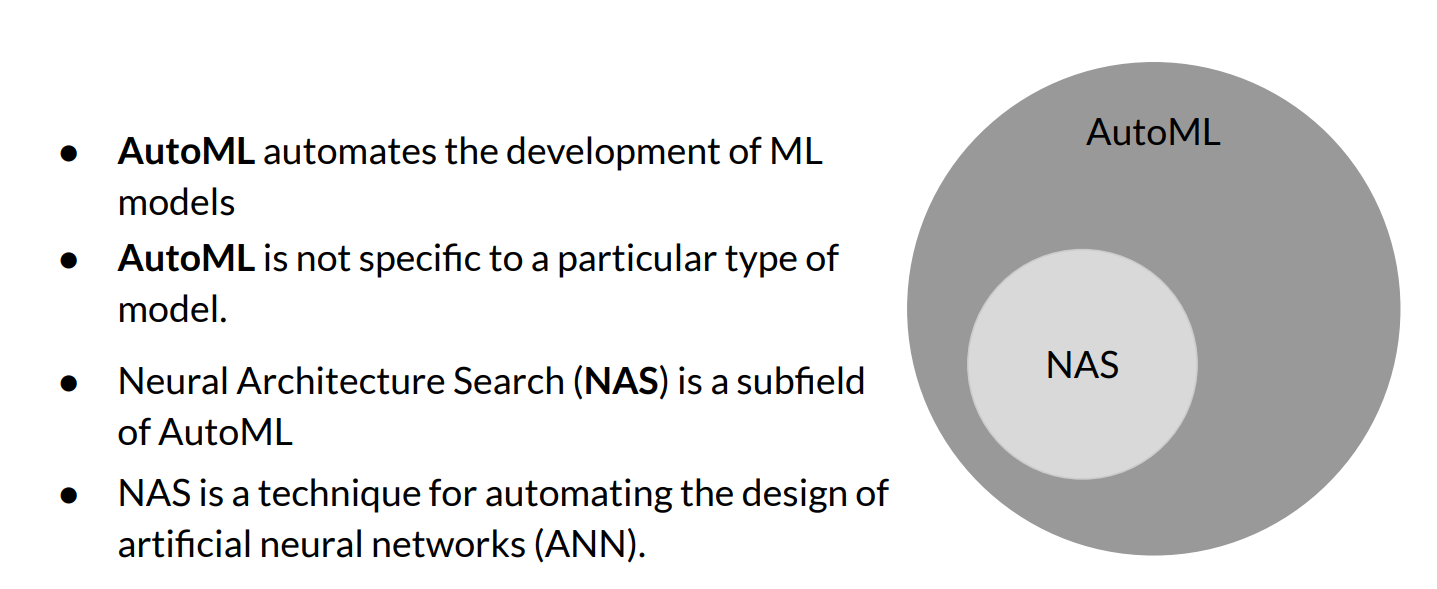

### 1.2.2 Understanding Search Spaces


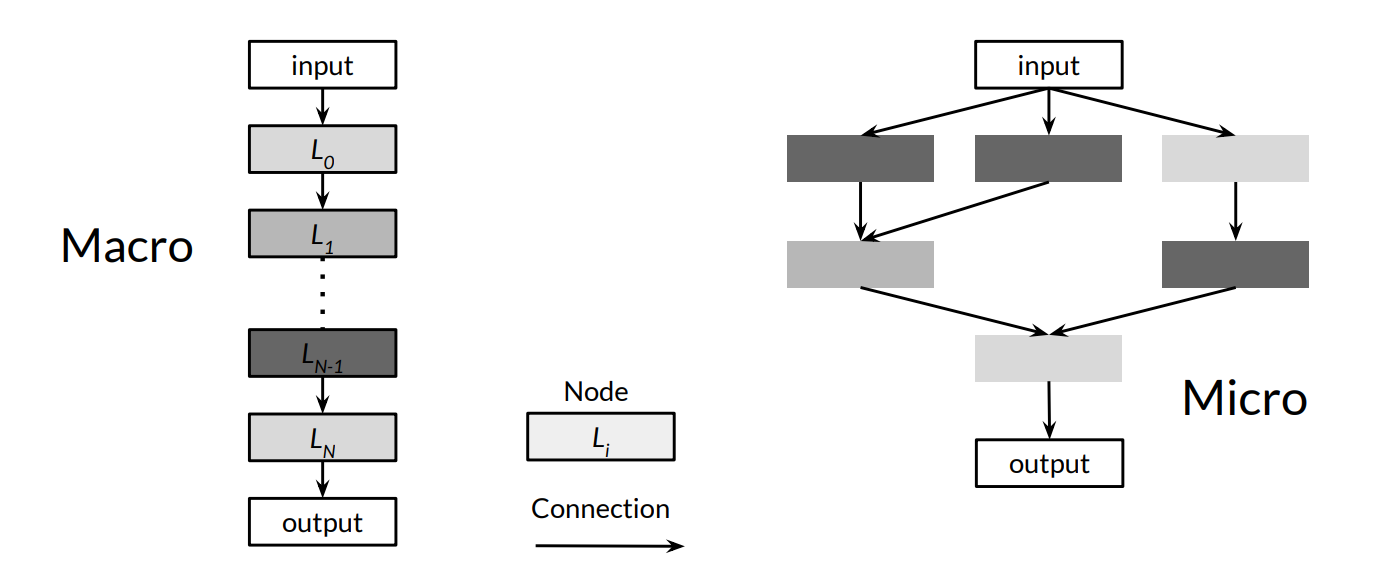

#### Macro Architecture Search Space


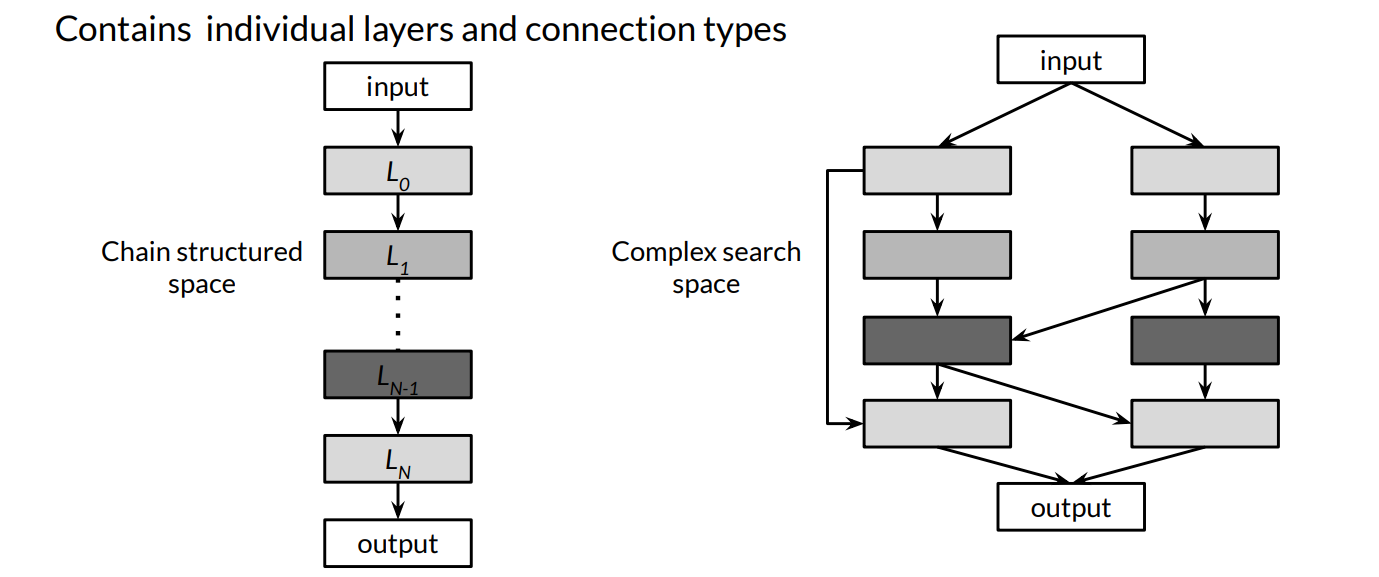

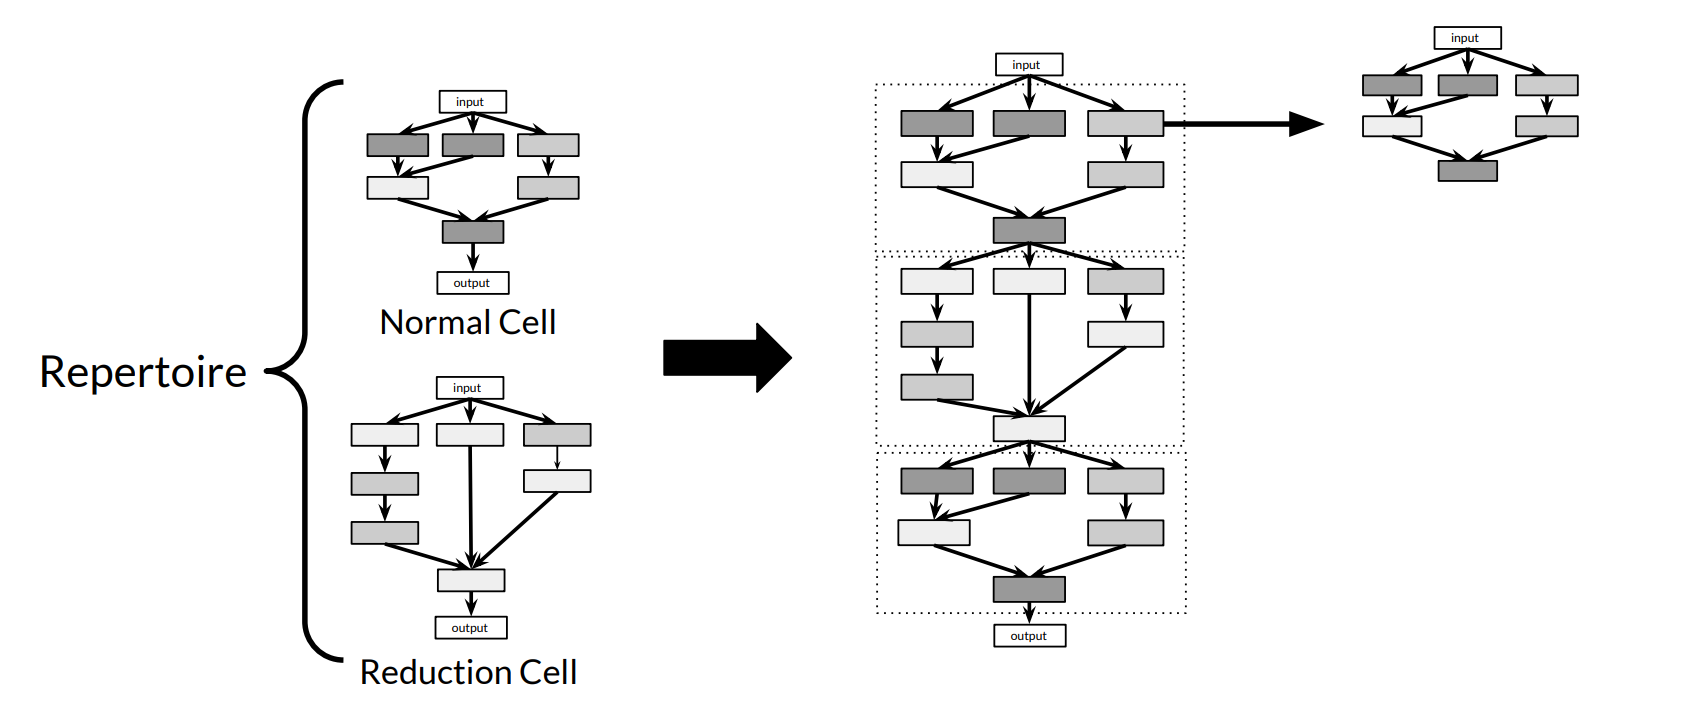

### 1.2.3 Search Strategies

#### Grid Search and Random Search


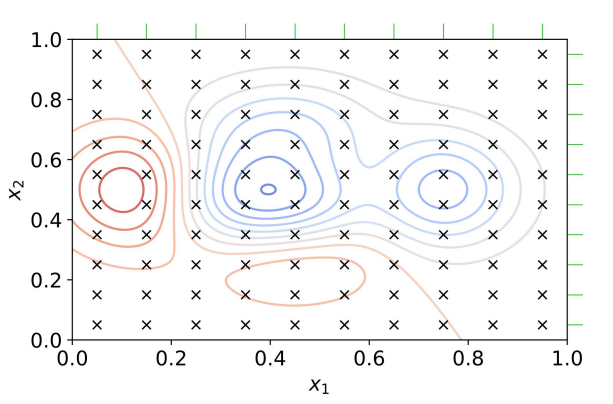

- Grid Search : Exhaustive search approach on fixed grid
values
- Random Search : Random Values
- Both suited for smaller search spaces.Both quickly fail with growing size of search space.


#### Bayesian Optimization


- Assumes that a specific probability
distribution, is underlying the performance.
- Tested architectures constrain the
probability distribution and guide the
selection of the next option.

#### Evolutionary Methods

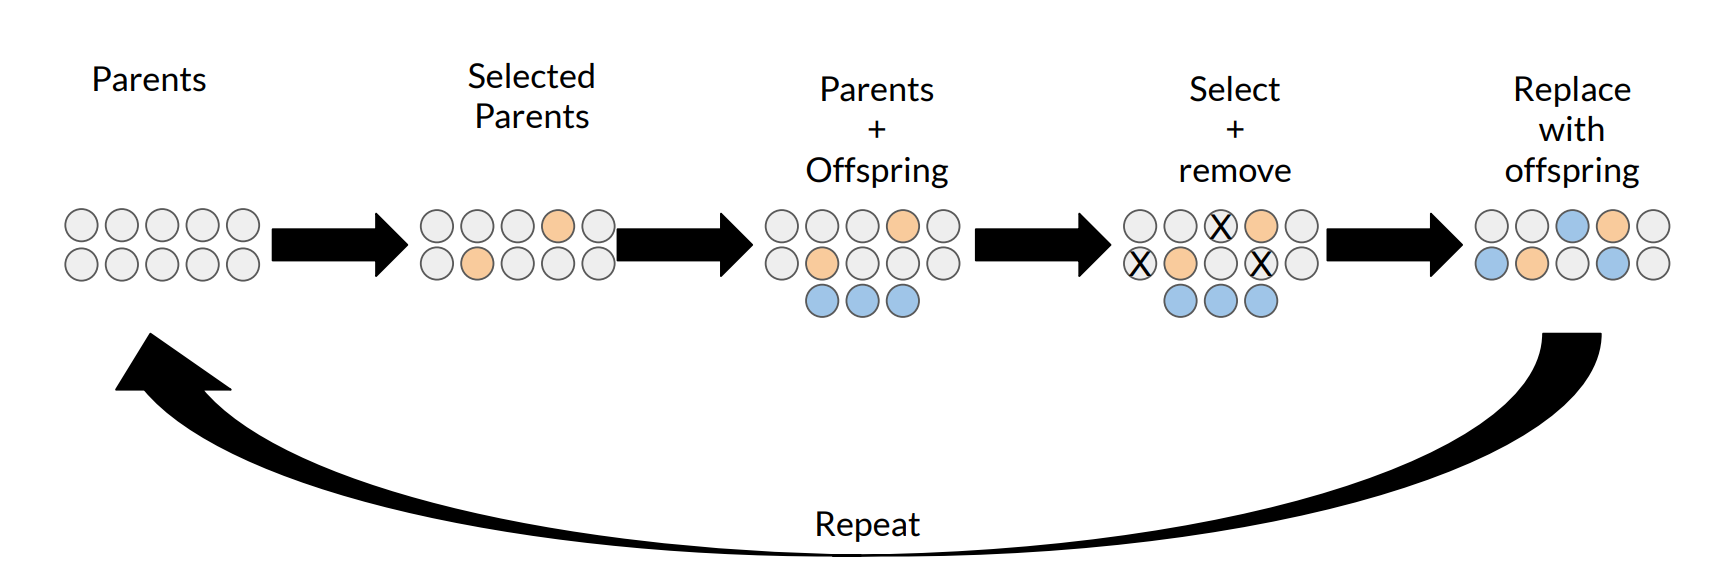

#### Reinforcement Learning


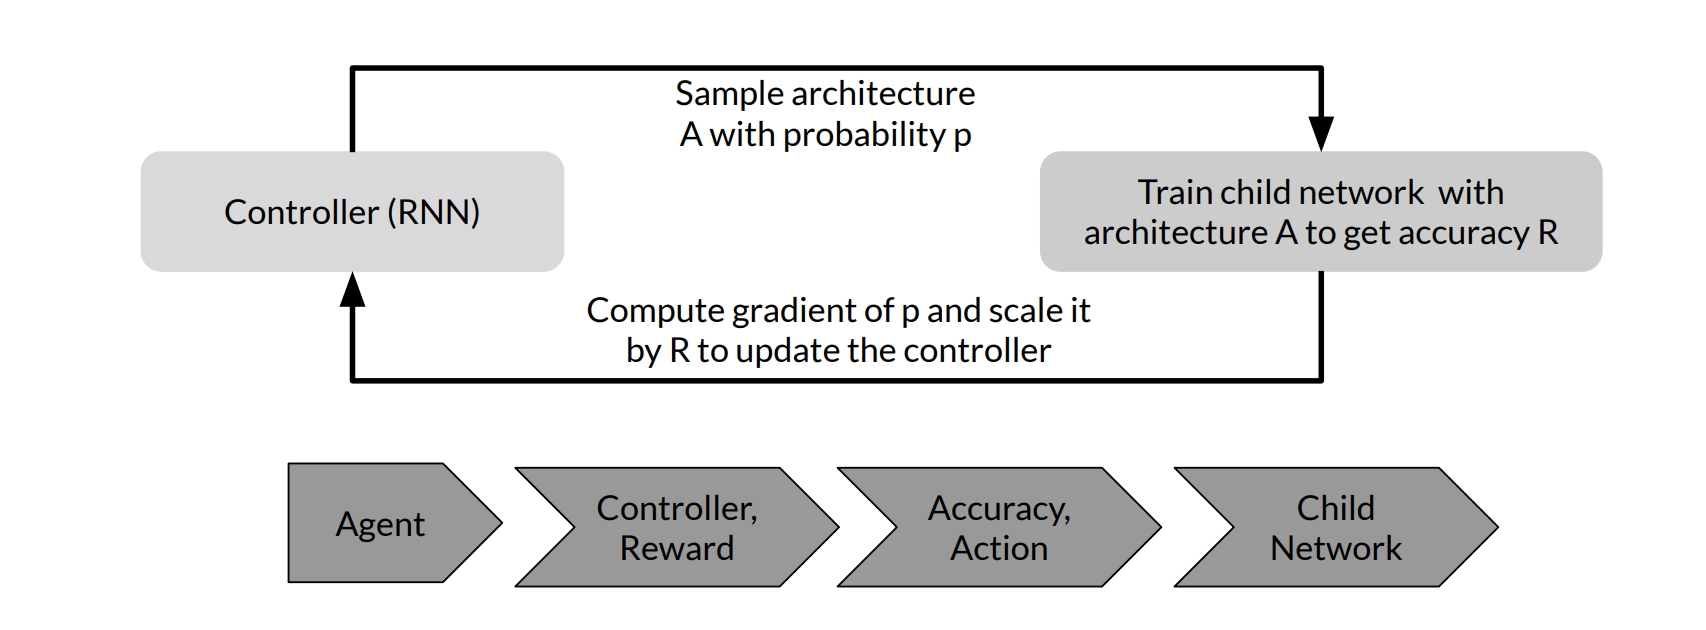

### 1.2.4 Measuring AutoML Efficacy


Strategies to Reduce the Cost :
1. Lower fidelity estimates
2. Learning Curve Extrapolation
3. Weight Inheritance/ Network Morphisms

#### Lower Fidelity Estimates


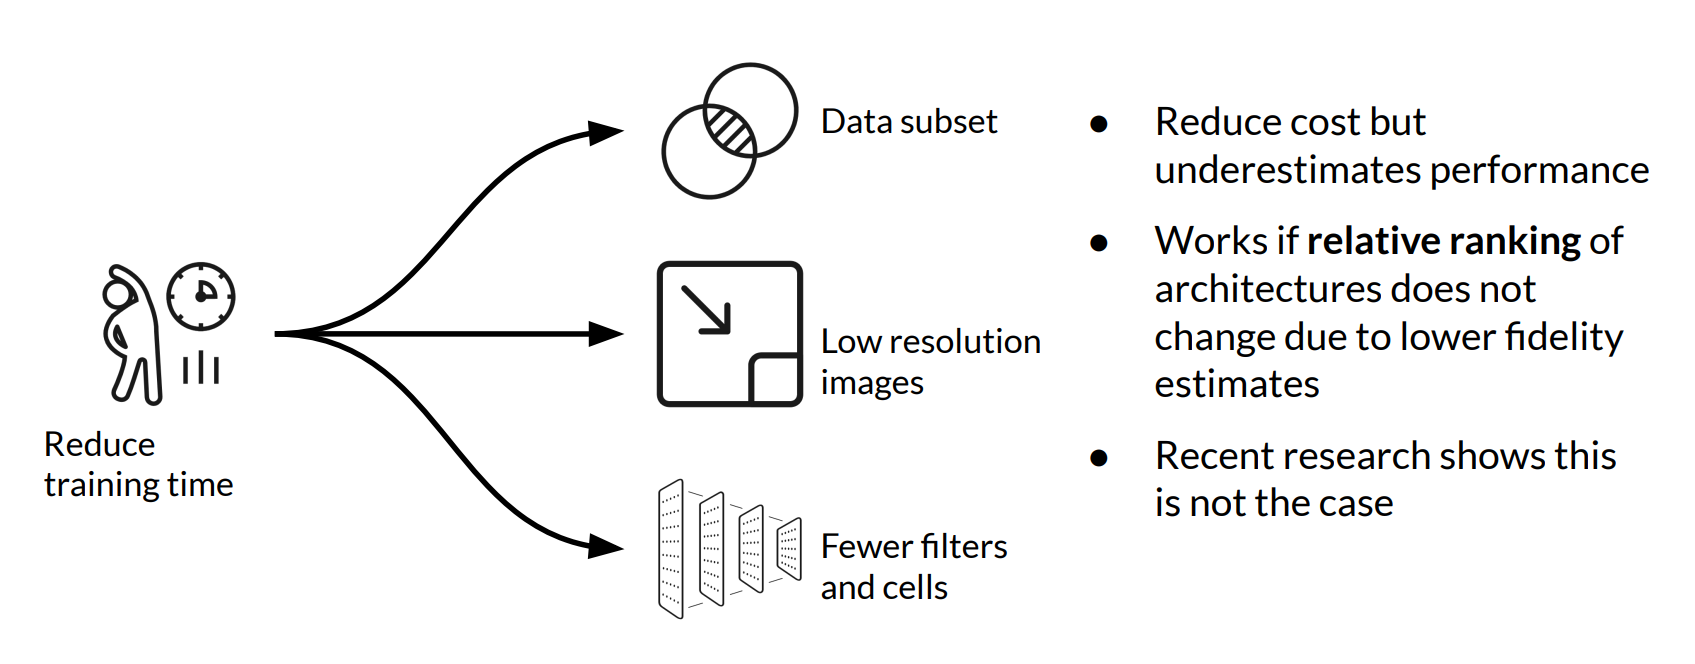

#### Learning Curve Extrapolation


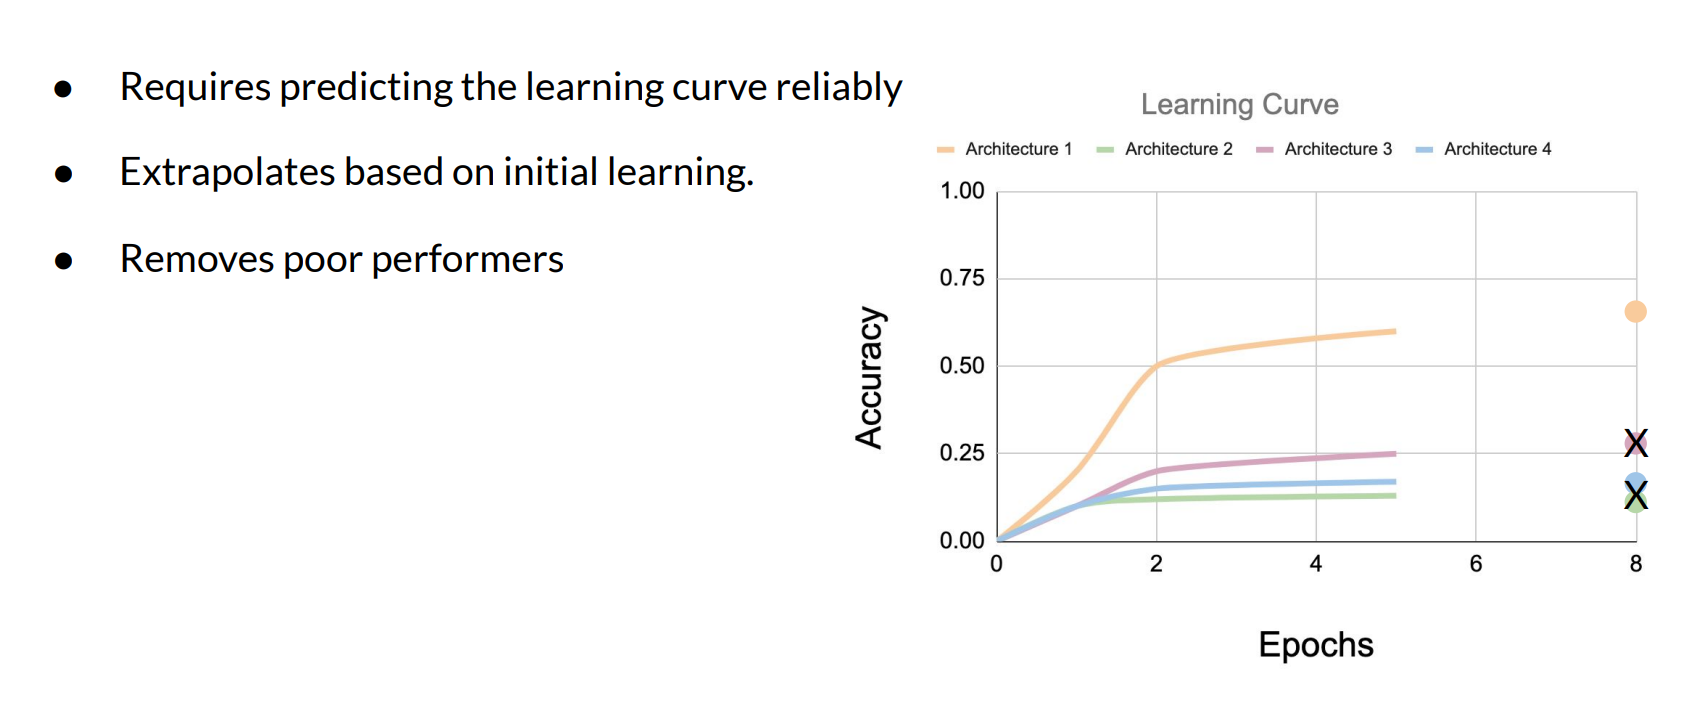

#### Weight Inheritance/Network Morphisms


- Initialize weights of new architectures based on previously trained
architectures
  - Similar to transfer learning
- Uses Network Morphism
- Underlying function unchanged
  - New network inherits knowledge from parent network.
  - Computational speed up: only a few days of GPU usage
  - Network size not inherently bounded


### 1.2.5 AutoML on the Cloud

#### Amazon SageMaker Autopilot

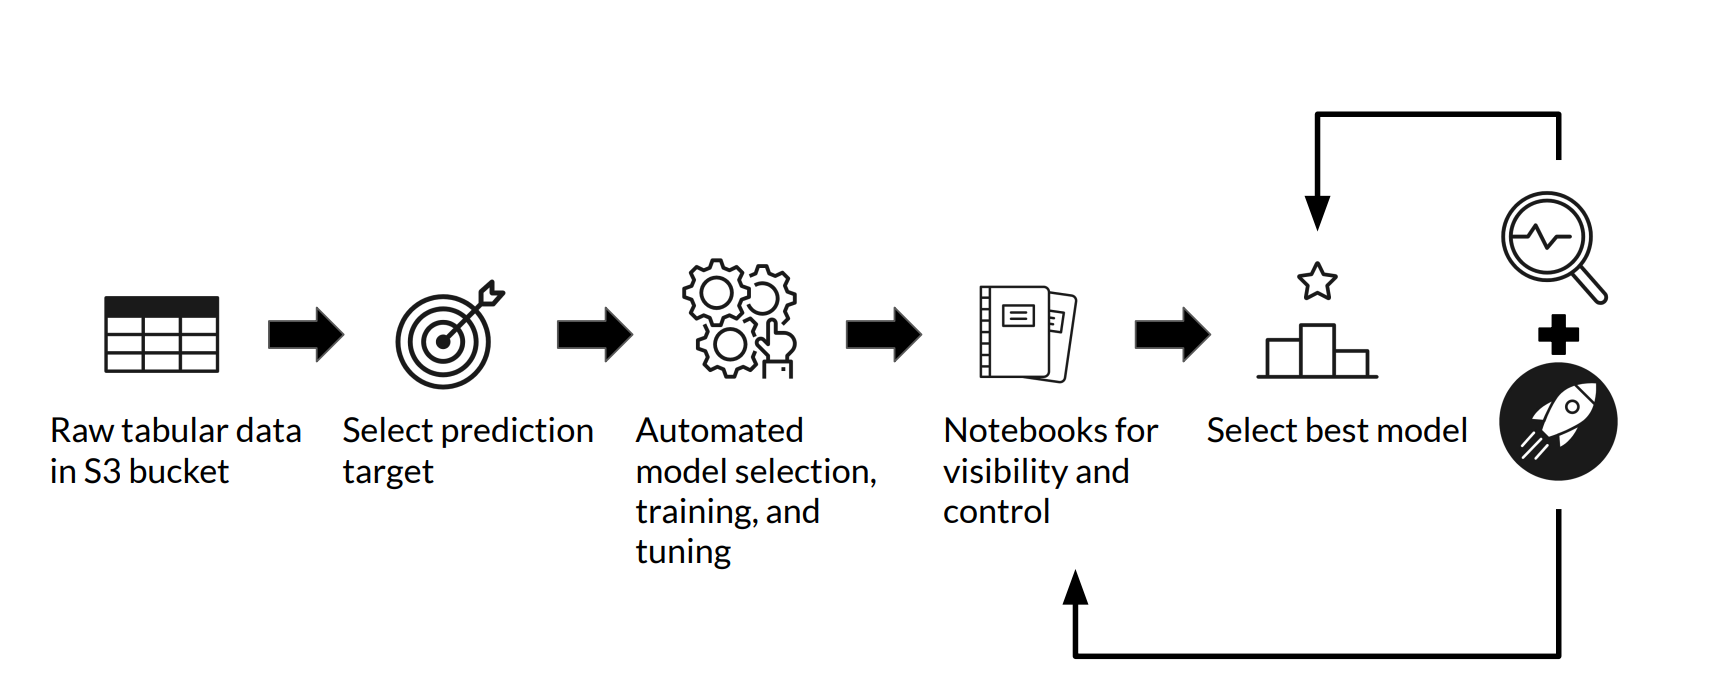

Key features :
- Quick Iteration
- High quality models
- Performance ranked
- Selected features
- Notebooks for reproducibility


Typical use cases :
- Price Prediction ( Stocks, Utilities , Real estate )
- Churn Prediction ( Prevent customer loss, Pattern analysis)
- Risk Assessment ( Individuals, Assets, Companies)






#### Microsoft Azure

Key features
- Quick customization ( Model, Control settings)
- Automated Feature Engineering
- Data Visualization
- Intelligent stopping
- Experiment summaries , Metric visualizations
- Model Interpretability
- Pattern Discovery



#### Google Cloud AutoML


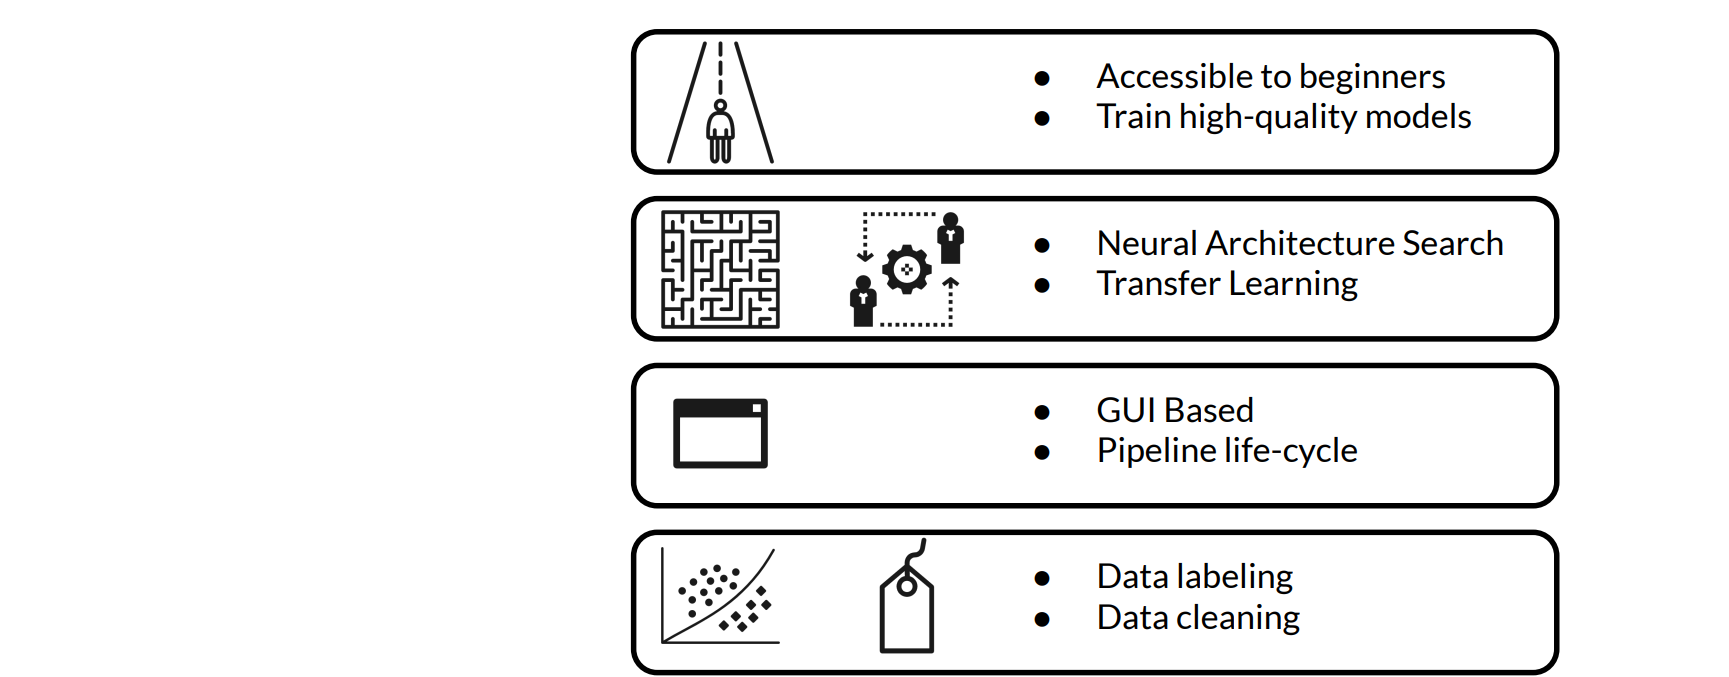

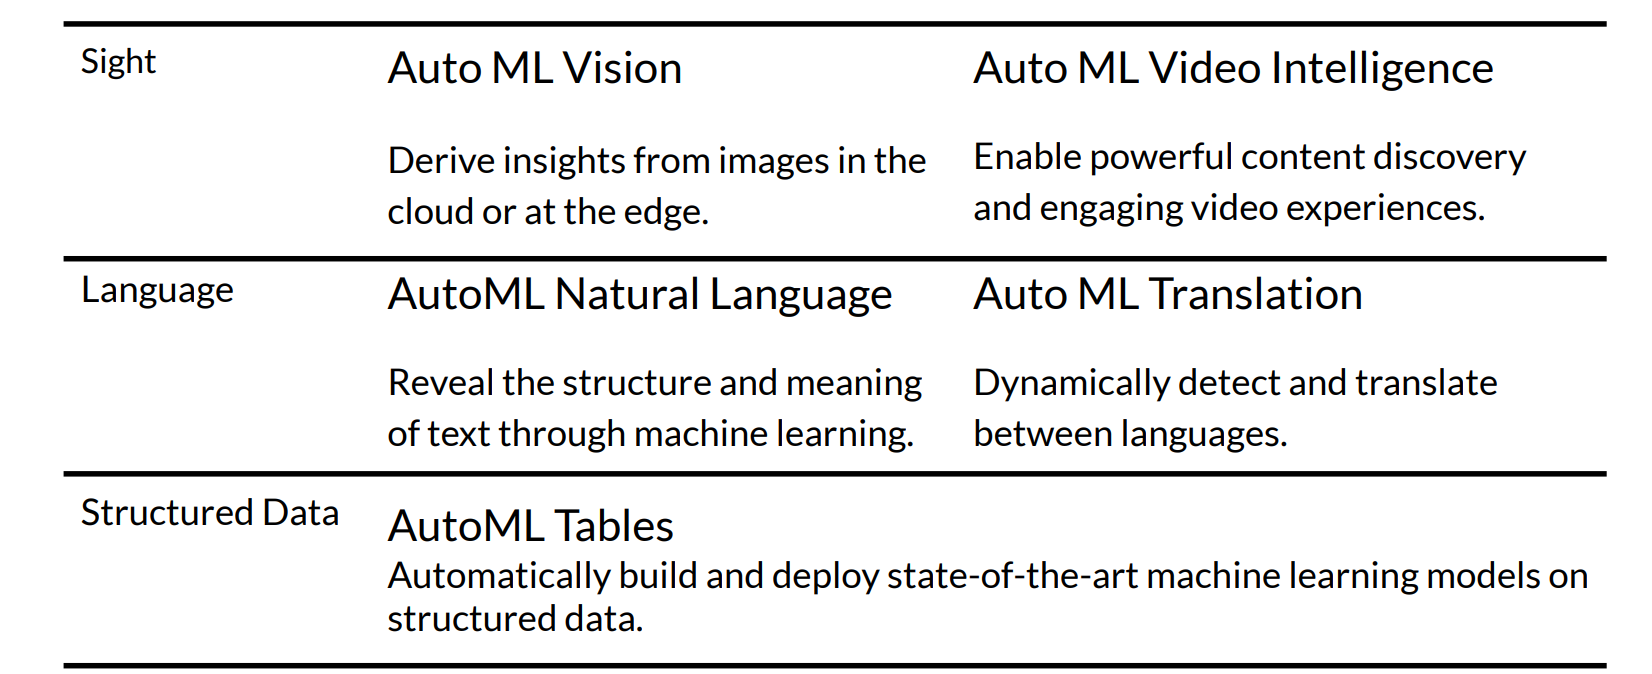

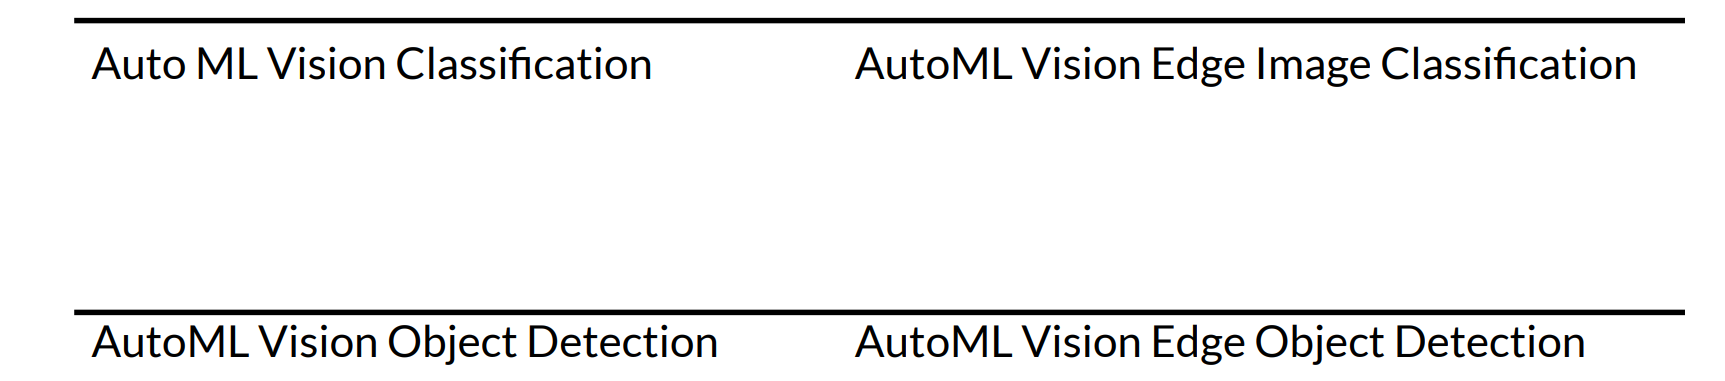

AutoML Video Intelligence Products


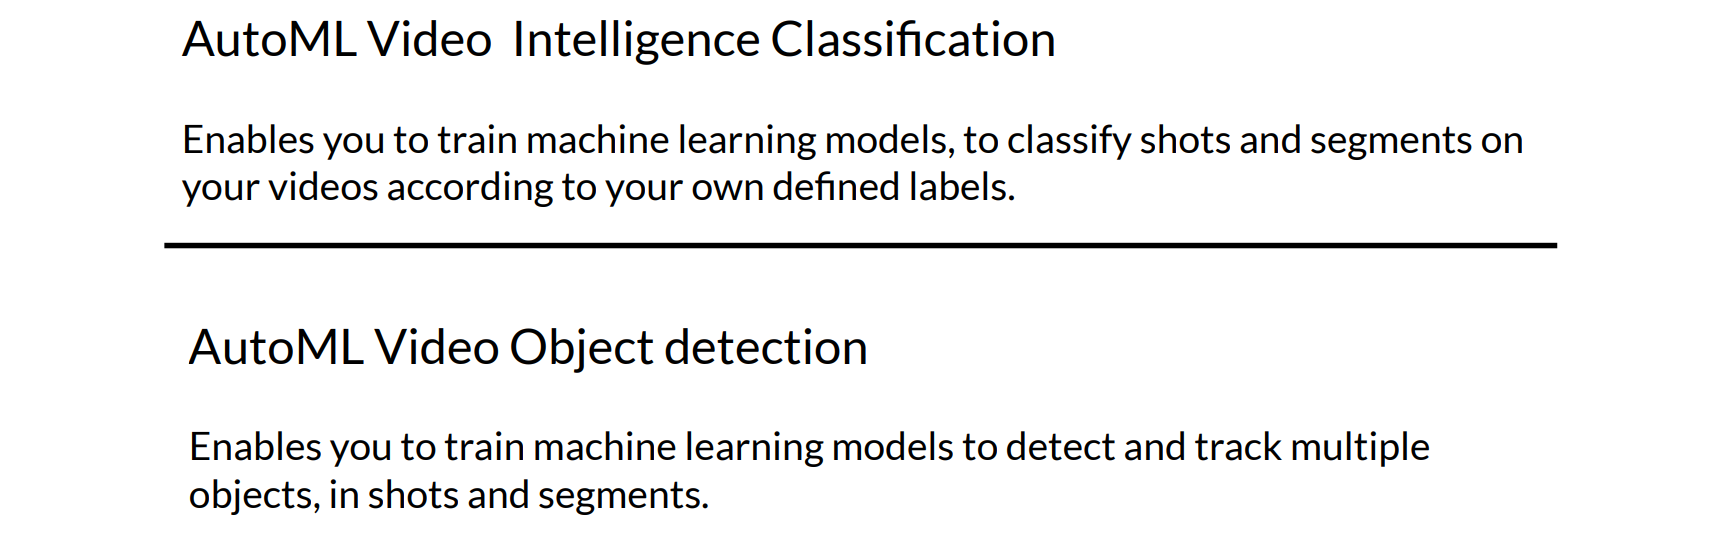